In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.pipeline import make_pipeline

In [60]:
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score

def meanAMI(labels, dataframe):
    mAMI= 0 
    
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        mAMI += featAMI/len(dataframe.columns)
    return mAMI

def get_maxAMI_feature(labels, dataframe):
    MAMI = 0
    MAMIfeat = dataframe.columns[0]
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        MAMIfeat = feat if featAMI > MAMI else MAMIfeat
        MAMI = max(MAMI, featAMI)
    return MAMIfeat


In [61]:
def greedy_optimizer(classifier, method="AMI"):
    """chooses the features tat maximise the classifier performance"""
    features = list(quant.columns)
    combos = [[col] for col in features]
    best_features = []
    for i in range(2):
        scores = []
        categories = []

        for feat in combos:
            Y = quant[feat]
            labels = classifier.fit_predict(Y)
            if method == "AMI":
                s = meanAMI(labels, categ)
            elif method == "silhouette":
                s = silhouette_score(Y, labels)
            else:
                print("optimizing method not in list")
            maxAMIfeat = get_maxAMI_feature(labels, categ)
            scores.append(s)
            categories.append(maxAMIfeat)
        
        best_score_index = np.argmax(scores)
        best_features.append(features[best_score_index])
        combos = [best_features + [f] for f in features if f not in best_features]
        features.remove(features[best_score_index]) 

        print(f"best {method} is for {best_features} (S = {scores[best_score_index]}). Best match in category {categories[best_score_index]}")
    return best_features


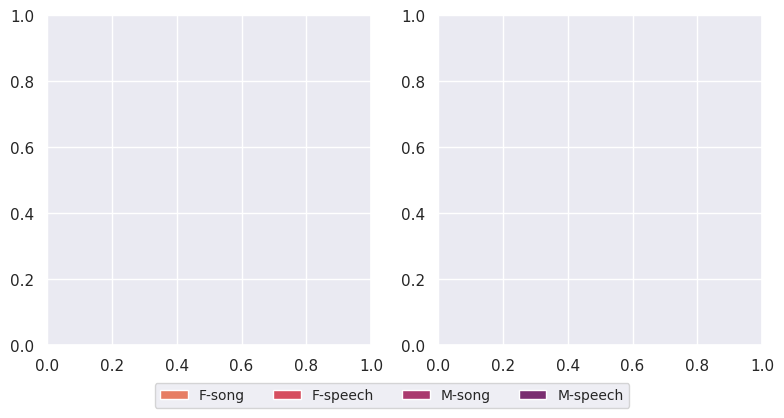

In [62]:
from matplotlib.patches import Patch
cmap= sns.color_palette("flare", 4)

fig, (ax2, ax1) = plt.subplots(1,2, figsize=(8,4))

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(4))}
get_codes = lambda x: np.vectorize(map_classes.get)(x)
codes = get_codes(classes).reshape(-1)

legend_elements = [ Patch(facecolor=cmap[0], label=unique_classes[0]),
                     Patch(facecolor=cmap[1], label=unique_classes[1]),
                     Patch(facecolor=cmap[2], label=unique_classes[2]),
                     Patch(facecolor=cmap[3], label=unique_classes[3])]

fig.legend(handles=legend_elements, loc='center', fontsize=10, bbox_to_anchor=(0.5,-0.01), ncols=4)

In [63]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = ["length_ms", "stft_min"] #greedy_optimizer(model, method="AMI")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.5, ax=ax1)

sns.scatterplot(data=quant, x=f1, y=f2,s=5, hue=codes, palette="flare", ax=ax1, edgecolor=None, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax1, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5,alpha=0.8)

ax1.set_xlim(min(quant[f1]), max(quant[f1]))
ax1.set_ylim(min(quant[f2]), max(quant[f2]))

plt.savefig("KMEANS-7clusters.pdf")

<Figure size 640x480 with 0 Axes>

In [64]:
kmeans = KMeans(n_clusters=2, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = ['sc_max', 'length_ms']#greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.5, ax=ax2, palette="flare")

sns.scatterplot(data=quant, x=f1, y=f2,s=5, hue=codes, palette="flare", ax=ax2, edgecolor=None, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax2, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5, alpha=0.8)
ax2.set_xlim(min(quant[f1]), max(quant[f1]))
ax2.set_ylim(min(quant[f2]), max(quant[f2]))

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


(2936.0, 6373.0)

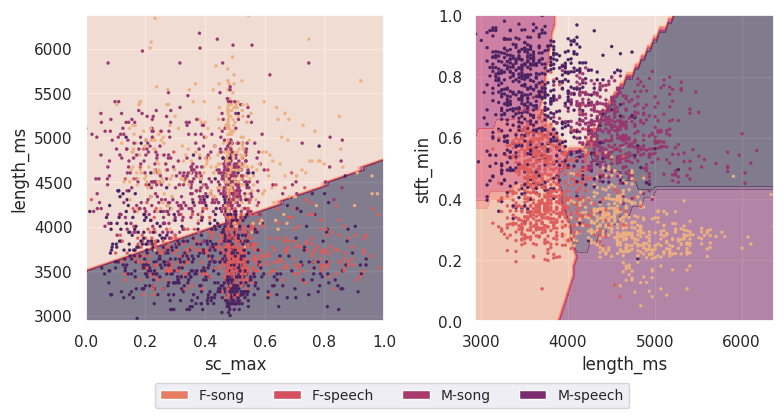

In [65]:
fig.tight_layout()
fig.savefig("kmeans_cluster_2_7.pdf", bbox_inches='tight')
display(fig)